## Summary

## Google colab

In [1]:
try:
    import google.colab
    GOOGLE_COLAB = True
except ImportError:
    GOOGLE_COLAB = False
    
GOOGLE_COLAB

False

In [2]:
if GOOGLE_COLAB:
    !pip install \
        transformers \
        https://gitlab.com/kimlab/kmbio/-/archive/v2.1.0/kmbio-v2.1.0.zip \
        https://gitlab.com/kimlab/kmtools/-/archive/v0.2.8/kmtools-v0.2.8.zip \
        

## Imports

In [3]:
import io
import tempfile
from pathlib import Path

import elaspic2 as el2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import torch
from kmbio import PDB
from kmtools import structure_tools
from scipy import stats
from tqdm.notebook import tqdm

In [4]:
%load_ext autoreload
%autoreload 2

## Parameters

In [5]:
NOTEBOOK_DIR = Path("10_stability_demo").resolve()
NOTEBOOK_DIR.mkdir(exist_ok=True)

NOTEBOOK_DIR

PosixPath('/home/kimlab4/strokach/workspace/elaspic-v2/notebooks/10_stability_demo')

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

device(type='cuda')

## Helper functions

In [7]:
def download_csv(url):
    header = {
        "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.75 Safari/537.36",
        "X-Requested-With": "XMLHttpRequest",
    }
    df = pd.read_csv(io.StringIO(requests.get(url, headers=header).text))
    return df

In [8]:
def structure_to_blob(structure):
    with tempfile.NamedTemporaryFile(suffix=".pdb") as out:
        PDB.save(structure, out.name)
        with open(out.name, "rt") as fin:
            data = fin.read()
    return data

In [9]:
def sequence_matches_structure(sequence, structure_blob):
    with tempfile.NamedTemporaryFile(suffix=".pdb") as tmp_file:
        with open(tmp_file.name, "wt") as fout:
            fout.write(structure_blob)
        structure = PDB.load(tmp_file.name)

    chain_sequence = structure_tools.get_chain_sequence(
        structure[0]["A"], if_unknown="replace", unknown_residue_marker=""
    )
    return sequence == chain_sequence

In [10]:
def parse_mutation_data(structure, stability_df):
    amino_acids = "GVALICMFWPDESTYQNKRH"
    assert len(set(amino_acids)) == 20

    chain_sequence = structure_tools.get_chain_sequence(
        structure[0]["A"], if_unknown="replace", unknown_residue_marker=""
    )
    resnum_to_idx_mapping = {r.id[1]: i for i, r in enumerate(structure[0]["A"])}

    mutations = []
    effects = []
    num_mismatches = 0
    for tup in stability_df.itertuples():
        idx = resnum_to_idx_mapping.get(tup.site_SARS2)
        if idx is None or chain_sequence[idx] != tup.wildtype:
            num_mismatches += 1
            continue
        if tup.wildtype not in amino_acids or tup.mutant not in amino_acids:
            if tup.mutant != "*":
                print(f"Skipping strange mutation {tup.wildtype} → {tup.mutant}.")
            continue
        elif tup.wildtype == tup.mutant:
            # Exclude "mutations" where the wildtype and mutant residues are the same
            continue
        elif pd.isnull(tup.expr_avg):
            # For some reason, the effect is missing in some rows
            continue
        mutations.append(f"{tup.wildtype}{idx + 1}{tup.mutant}")
        effects.append(tup.expr_avg)
    print(f"Num mismatches: {num_mismatches}.")

    results = [
        {
            "dataset": NOTEBOOK_DIR.name,
            "name": f"spike-unbound|spike-closed",
            "protein_sequence": chain_sequence,
            "mutation": mutations,
            "effect": effects,
            "effect_type": "Deep mutation scan",
            "protein_structure": structure_to_blob(structure),
        }
    ]
    return results

## Workspace

### Load protein structure

In [11]:
structure_ref = PDB.load("rcsb://6ZOY.pdb")

In [12]:
PDB.view_structure(structure_ref)

NGLWidget()

In [13]:
structure = structure_tools.extract_domain(structure, [structure_tools.DomainDef(0, "A", 260, 480)])

In [14]:
PDB.view_structure(structure)

NGLWidget()

### Load a list of mutations

In [15]:
stability_df = download_csv("https://ars.els-cdn.com/content/image/1-s2.0-S0092867420310035-mmc2.csv")

In [16]:
stability_df.head()

,site_RBD,site_SARS2,wildtype,mutant,mutation,mutation_RBD,bind_lib1,bind_lib2,bind_avg,expr_lib1,expr_lib2,expr_avg
0,1,331,N,A,N331A,N1A,-0.05,-0.02,-0.03,-0.14,-0.08,-0.11
1,1,331,N,C,N331C,N1C,-0.08,-0.10,-0.09,-1.56,-0.97,-1.26
2,1,331,N,D,N331D,N1D,0.00,0.07,0.03,-0.75,-0.12,-0.44
3,1,331,N,E,N331E,N1E,0.02,-0.02,0.00,-0.39,-0.24,-0.31
4,1,331,N,F,N331F,N1F,-0.03,-0.16,-0.10,-0.83,-0.57,-0.70


### Parse mutation data

In [17]:
protein_mutation_info = parse_mutation_data(structure, stability_df)[0]

list(protein_mutation_info.keys())

Num mismatches: 21.


['dataset',
 'name',
 'protein_sequence',
 'mutation',
 'effect',
 'effect_type',
 'protein_structure']

### Featurize model

In [18]:
model = el2.ELASPIC2(device=device)

In [19]:
structure_file_obj = tempfile.NamedTemporaryFile(suffix=".pdb")
PDB.save(structure, structure_file_obj.name)

protein_stability_features = model.build(
    structure_file=structure_file_obj.name,
    protein_sequence=protein_mutation_info["protein_sequence"],
    ligand_sequence=None,
    remove_hetatms=True,
)

In [20]:
protein_stability_features

ELASPIC2Data(is_interface=False, protbert_data=ProtBertData(sequence='QPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVCPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKSTNLVKNKCVNF'), proteinsolver_data=Data(edge_attr=[9590, 2], edge_index=[2, 9590], x=[221]))

### Featurize mutations

In [21]:
mutation_stability_features = list(
    tqdm(
        (
            model.analyze_mutation(mut, protein_stability_features)
            for mut in protein_mutation_info["mutation"]
        ),
        total=len(protein_mutation_info["mutation"]),
    )
)

### Predict mutation effects on stability

In [22]:
# Reverse the effect value, because higher values mean more stable (opposite of ΔΔG)
stability_pred = model.predict_mutation_effect(mutation_stability_features)
stabiliby_actual = -np.array(protein_mutation_info["effect"])

### Show results

In [23]:
mask = np.isnan(stabiliby_actual)
stability_pred = stability_pred[~mask]
stabiliby_actual = stabiliby_actual[~mask]

In [24]:
corr = stats.spearmanr(stability_pred, stabiliby_actual)

corr

SpearmanrResult(correlation=0.6075481382014631, pvalue=0.0)

Text(0.02, 0.97, "Spearman's ρ = 0.6075 (p = 0.00e+00)")

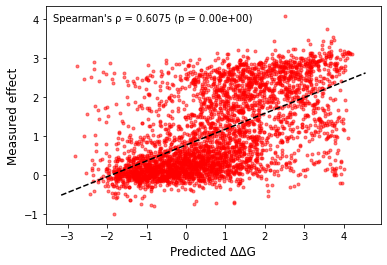

In [25]:
fg, ax = plt.subplots()

ax.plot(stability_pred, stabiliby_actual, "r.", alpha=0.5)

z = np.polyfit(stability_pred, stabiliby_actual, 1)
p = np.poly1d(z)
x = np.linspace(*ax.get_xlim(), 100)
ax.plot(x, p(x), "k--")

ax.set_xlabel("Predicted ΔΔG", fontsize="large")
ax.set_ylabel("Measured effect", fontsize="large")
ax.text(
    0.02,
    0.97,
    f"Spearman's ρ = {corr[0]:.4f} (p = {corr[1]:.2e})",
    ha="left",
    va="top",
    transform=ax.transAxes,
)